In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
BASE_DIR = "/kaggle/input/100-bird-species"
paths_df = pd.read_csv(os.path.join(BASE_DIR, "birds.csv"))
paths_df.drop(46620, axis= 0, inplace=True) # The dataset as of 9-Jan-2023 contains a file that is 
# present at the given index whose dimension is not 224x224. Removing the file to avoid unnecessary complexity in the code
labels = paths_df["class id"].unique()
bird_name_map = {int(i): paths_df[paths_df["class id"] == i]["labels"].values[0] for i in labels}
    


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install torchvision

In [3]:
!pip install torchmetrics

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import torch
from torch import nn
from PIL import Image
import torchmetrics
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision import models
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from timeit import default_timer as timer
from tqdm.auto import tqdm
from torch.cuda import amp
from torch.cuda.amp import autocast, GradScaler
# import torch_xla
# import torch_xla.core.xla_model as xm
from torchmetrics import Accuracy, ConfusionMatrix

In [5]:
torch.__version__

'1.13.0'

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [7]:
paths_df.head()

class id                      filepaths           labels data set  \
0         0  train/ABBOTTS BABBLER/001.jpg  ABBOTTS BABBLER    train   
1         0  train/ABBOTTS BABBLER/002.jpg  ABBOTTS BABBLER    train   
2         0  train/ABBOTTS BABBLER/003.jpg  ABBOTTS BABBLER    train   
3         0  train/ABBOTTS BABBLER/004.jpg  ABBOTTS BABBLER    train   
4         0  train/ABBOTTS BABBLER/005.jpg  ABBOTTS BABBLER    train   

        scientific name  
0  Malacocincla abbotti  
1  Malacocincla abbotti  
2  Malacocincla abbotti  
3  Malacocincla abbotti  
4  Malacocincla abbotti

In [8]:
paths_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85084 entries, 0 to 85084
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   class id         85084 non-null  int64 
 1   filepaths        85084 non-null  object
 2   labels           85084 non-null  object
 3   data set         85084 non-null  object
 4   scientific name  85084 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.9+ MB


<BarContainer object of 3 artists>

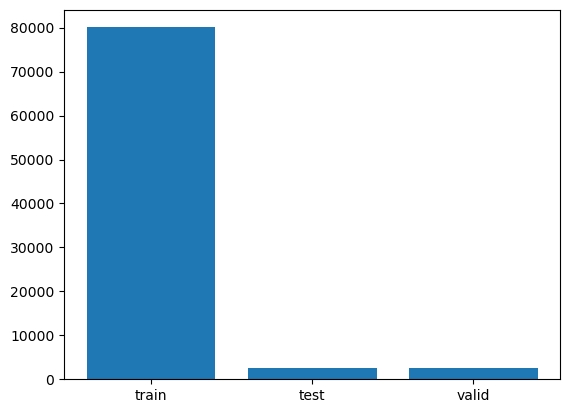

In [9]:
dataset_split = paths_df["data set"].value_counts()
plt.bar(dataset_split.index, dataset_split.values)

In [10]:
class BirdDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.iloc[idx]['filepaths']
        img_name = os.path.join(BASE_DIR, img_path)
        image = Image.open(img_name).convert('RGB')

        if image.size != (224, 224):
            transform = torchvision.transforms.Resize((224, 224))
            image = transform(image)
        
        image = self.transform(image)
        label = self.df.iloc[idx]['class id']

        return image, label

In [11]:
resnet = models.resnet34(weights='DEFAULT').to(device)

# Replace the last layer with a new fully connected layer that has 500 output features
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 500)

# Set the model to evaluation mode
resnet.eval()

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [13]:
# Train
train_df =  paths_df[paths_df['data set'] == 'train']

train_dataset = BirdDataset(train_df, transforms.Compose([transforms.RandomHorizontalFlip(), transform]))

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)

# Test

test_df = paths_df[paths_df['data set'] == 'test']

test_dataset = BirdDataset(test_df, transform)

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=0)

# Validation
valid_df = paths_df[paths_df['data set'] == 'valid']

valid_dataset = BirdDataset(valid_df, transform)

valid_dataloader = DataLoader(valid_dataset, batch_size=128, shuffle=True, num_workers=0)

In [14]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(80084, 2500, 2500)

In [15]:
len(train_dataloader)

626

In [16]:
train_dataset.transform

Compose(
    RandomHorizontalFlip(p=0.5)
    Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
)

In [17]:
test_dataset.transform

Compose(
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [18]:
image, label = train_dataset.__getitem__(0)
image, label

(tensor([[[0.9646, 1.0673, 1.0844,  ..., 0.9817, 0.9817, 0.9303],
          [0.9988, 1.1358, 1.1529,  ..., 0.9988, 0.9303, 0.9303],
          [1.0673, 1.2214, 1.2385,  ..., 1.0331, 0.9646, 1.0159],
          ...,
          [0.5022, 0.8276, 0.9303,  ..., 1.1187, 1.1529, 0.7762],
          [0.5536, 0.5022, 0.6392,  ..., 1.0331, 0.9988, 0.7591],
          [0.5707, 0.5536, 0.7419,  ..., 0.7591, 0.9646, 0.3994]],
 
         [[0.9755, 1.0805, 1.0980,  ..., 1.0980, 1.0980, 1.0980],
          [1.0105, 1.1506, 1.1681,  ..., 1.1331, 1.0455, 1.0980],
          [1.0805, 1.2381, 1.2731,  ..., 1.1681, 1.0980, 1.1331],
          ...,
          [0.3627, 0.7479, 0.8529,  ..., 1.2906, 1.2731, 0.8880],
          [0.4153, 0.4153, 0.5553,  ..., 1.2731, 1.2031, 0.9580],
          [0.4328, 0.4153, 0.6604,  ..., 1.0280, 1.2381, 0.6429]],
 
         [[0.7925, 0.8971, 0.9145,  ..., 1.6814, 1.6814, 1.6640],
          [0.8274, 0.9668, 1.0191,  ..., 1.6640, 1.6291, 1.6640],
          [0.9319, 1.0888, 1.1585,  ...,

In [19]:
image.shape, label

(torch.Size([3, 224, 224]), 0)

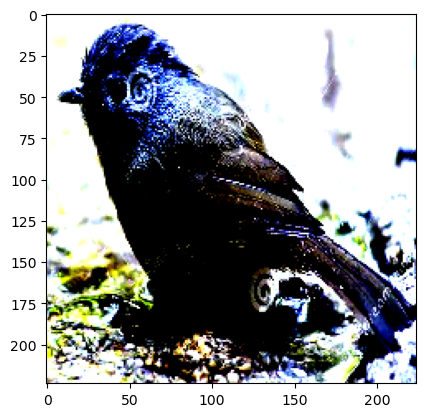

In [20]:
plt.imshow(image.permute(1, 2, 0))

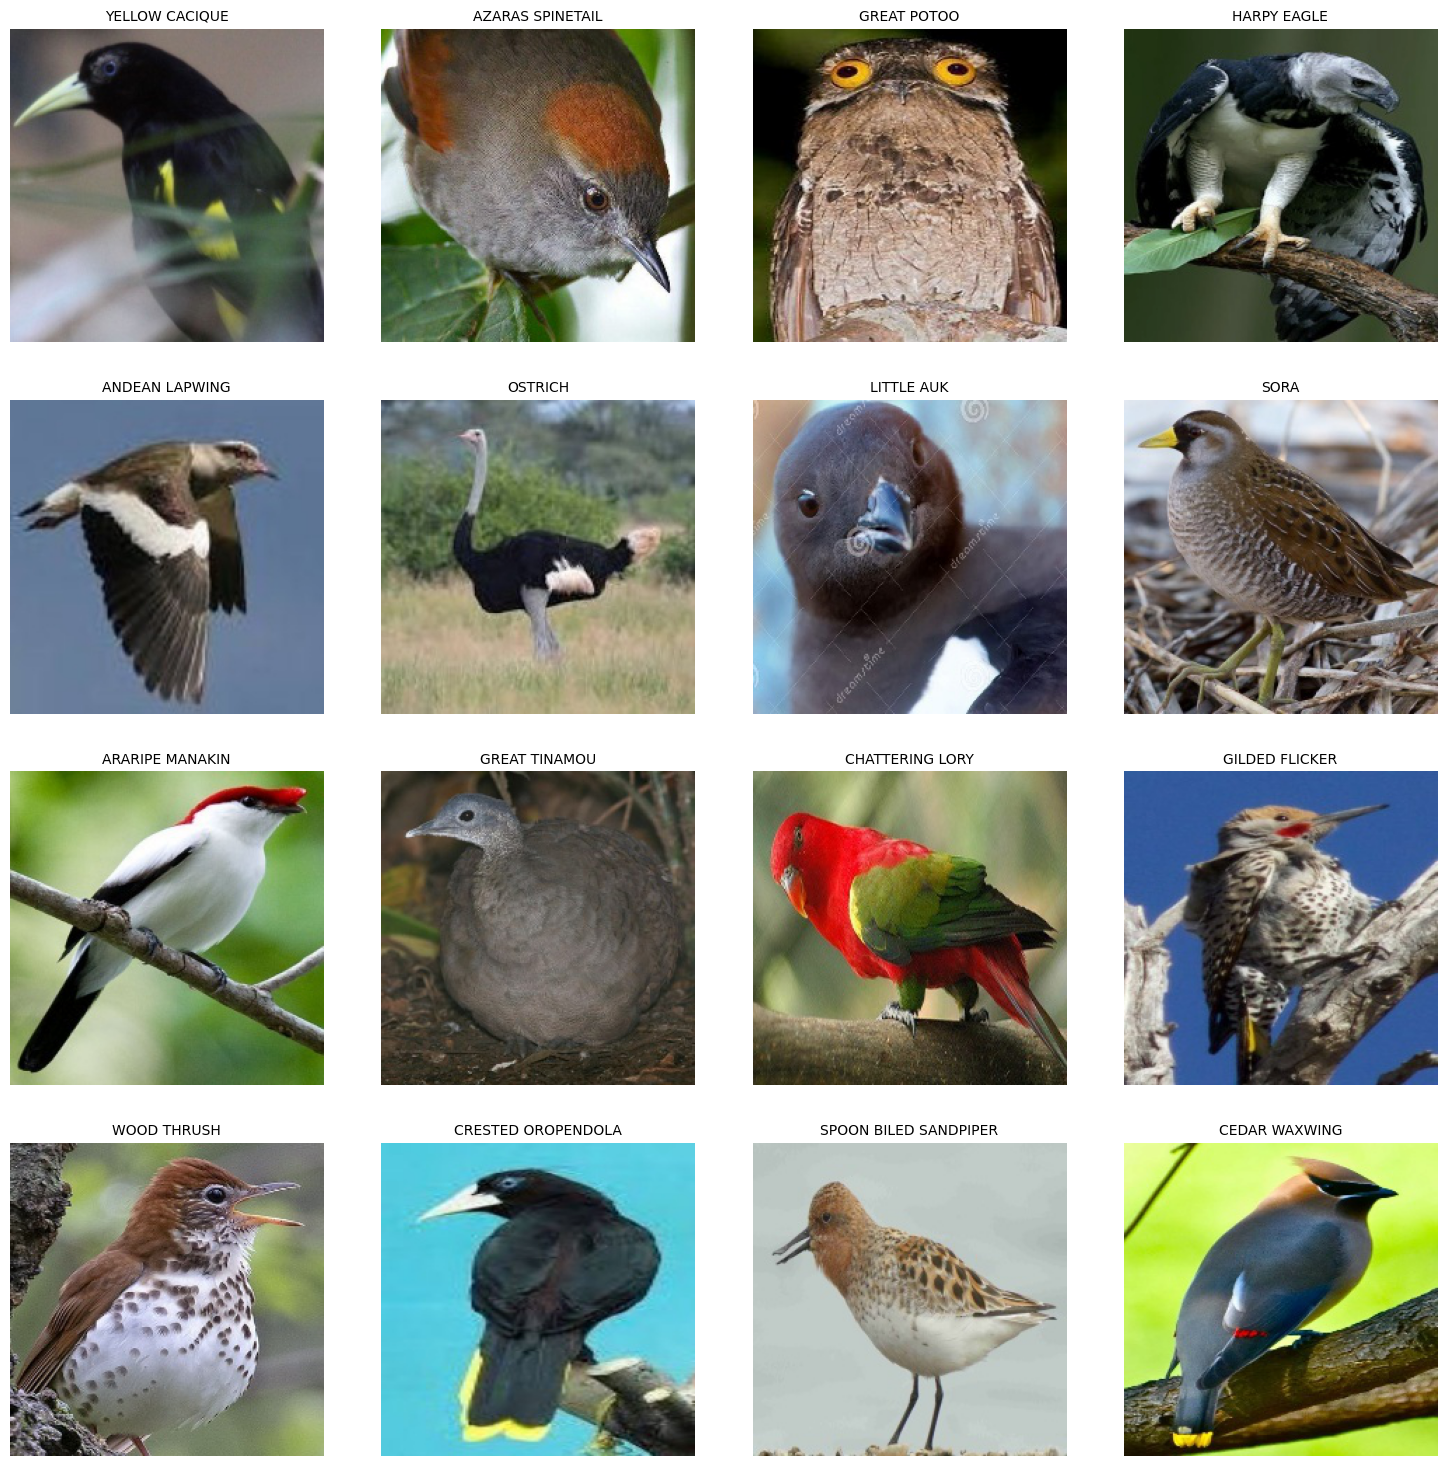

In [21]:
def denormalize(img):
    means = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    stds = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * stds + means

def show_batch(images, labels, class_map):
    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            image = denormalize(images[i*4 + j]).permute(1, 2, 0)
            label = labels[i*4 + j].item()
            ax[i][j].imshow((image.numpy() * 255).astype(np.uint8))
            title = class_map[label]
            ax[i][j].set_title(title)
            ax[i][j].axis('off')
            ax[i][j].title.set_fontsize(10)

    plt.show()

images, labels = next(iter(train_dataloader))
show_batch(images, labels, bird_name_map)

In [22]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch, train_labels_batch

(tensor([[[[ 0.2967,  0.2796,  0.2796,  ..., -0.1999, -0.1828, -0.1999],
           [ 0.2967,  0.2967,  0.2967,  ..., -0.2171, -0.2171, -0.2513],
           [ 0.2796,  0.2967,  0.3138,  ..., -0.2342, -0.2513, -0.2684],
           ...,
           [ 1.1358,  1.0159,  1.2557,  ...,  0.2282,  0.2624,  0.2111],
           [ 0.9303,  0.9988,  1.2043,  ...,  0.2967,  0.3481,  0.1939],
           [ 0.9988,  0.9646,  1.0844,  ...,  0.3652,  0.4337,  0.1939]],
 
          [[-0.1099, -0.1275, -0.1275,  ..., -0.3725, -0.3550, -0.3725],
           [-0.1099, -0.1099, -0.1099,  ..., -0.3901, -0.3901, -0.4251],
           [-0.1099, -0.0749, -0.0574,  ..., -0.4076, -0.4251, -0.4426],
           ...,
           [ 1.2731,  1.1506,  1.3957,  ..., -0.1450, -0.1099, -0.1625],
           [ 1.1506,  1.1856,  1.3957,  ..., -0.0749, -0.0224, -0.1800],
           [ 1.2206,  1.1856,  1.2906,  ..., -0.0049,  0.0651, -0.1800]],
 
          [[-0.8284, -0.8633, -0.8981,  ..., -0.9156, -0.8981, -0.9156],
           [-

In [23]:
next(resnet.parameters()).device

device(type='cuda', index=0)

In [24]:
dummy_x = torch.rand([1, 3, 224, 224]).to(device)
resnet.eval()
resnet.to(device)
with torch.inference_mode():
    pr = resnet(dummy_x.to('cuda'))
pr

tensor([[ 0.4817,  0.0977,  0.3517, -0.3201,  0.0954, -0.3314, -0.1005, -0.6917,
          0.7379,  0.0478,  0.0505, -0.2820, -0.3350, -0.1386, -0.6397,  0.2785,
         -0.1135, -0.5336, -0.4168, -0.2478,  0.0095, -0.7499,  0.6170,  0.2173,
          0.9855, -0.0491, -0.2284, -0.1934, -0.0829,  0.0036, -0.2519, -0.1461,
          0.0674,  0.2152, -0.2296, -0.6368, -0.6109, -0.4843, -0.1387,  0.1533,
          0.0660, -0.1802,  0.2875,  0.1401,  0.3033, -0.7696,  0.4269, -0.4904,
          0.0966,  0.4427, -0.3919, -1.0363,  0.1015,  0.1135, -0.6923, -0.5639,
          0.3869,  0.5783, -0.2147, -0.6725, -0.1782,  0.1976,  0.1298,  0.0951,
         -0.1247, -0.0442, -0.4062, -0.2681, -0.2380, -0.0212, -0.0387, -0.6341,
          0.4864, -0.5399,  0.1957, -0.0639, -0.4222,  0.2733,  0.2598,  0.4838,
         -0.3559,  0.3683,  0.0044, -0.6528, -0.4189, -0.1207, -0.3886,  0.7441,
         -0.2675,  0.0481,  0.0963, -0.1515, -0.7577,  0.0463,  0.5776, -0.2779,
         -0.0395, -0.2476,  

In [25]:
epochs = 10

scaler = GradScaler()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=0.01, weight_decay=1e-05)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001)
accuracy = Accuracy(task='multiclass', num_classes=500).to(device)

In [26]:
def print_time(start: float, end: float, device: torch.device=None):
  print(f'Train time on {device}: {end-start: .3f}s')
  return end-start

In [27]:
img, lbl = next(iter(train_dataloader))
outputs = resnet(img.to(device))
outputs.shape

torch.Size([128, 500])

In [28]:
lbl

tensor([238, 255, 121, 205, 427, 319, 403, 243, 480, 227, 127,  90, 338, 157,
        161, 307,  90, 201, 124,  11, 239, 260,  36, 112, 348, 117,  30, 193,
        404, 211, 384, 336, 398, 147, 441, 456, 241, 193, 448, 465, 221, 392,
        384, 268, 474, 128, 444,   5, 324, 487,  44,  13, 457, 336, 251,  21,
        374, 453, 204, 260, 282, 126, 141, 306, 422,  34, 240,  93, 401,  20,
        141, 481, 417, 272, 244, 120, 107, 259, 451, 446, 322, 387, 462,  59,
        403, 317, 370, 121, 478, 212, 234, 221,  39, 446, 313, 313, 323, 499,
        251, 445,  38, 338, 472, 262,  30, 210,  14, 463, 236,  51, 478,  96,
        365, 481, 295, 265,  97,  98, 435, 358,  70, 269, 359, 182, 150, 173,
        420, 296])

In [29]:
outputs

tensor([[ 0.6474,  0.7914,  0.1574,  ...,  0.4225, -0.5318, -0.0877],
        [ 0.5466,  0.1363,  0.3700,  ...,  0.6275, -0.1644, -0.1721],
        [ 0.4632,  0.2895, -0.1238,  ..., -0.4520, -0.8691,  0.0194],
        ...,
        [ 0.2599,  0.7039, -0.1156,  ..., -0.1354, -0.5550, -0.2433],
        [ 0.6387, -0.4035, -0.5045,  ..., -0.3457, -0.7360, -0.1089],
        [ 0.1584, -0.0224,  0.0931,  ..., -0.1576, -0.0939, -0.9277]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

resnet_start = timer()


torch.autograd.set_detect_anomaly(True)

train_losses = []
train_acc = []
val_losses = []
val_acc = []

for epoch in tqdm(range(epochs)):
    print(f'Epoch: {epoch + 1}\n--------')
    running_loss = 0.0
    
    for image,labels in train_dataloader:
        resnet.train()
        num_batches = 0
        
        image, labels = image.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast(): # Mixed Point Training
        
            outputs = resnet(image)
        
            loss = loss_fn(outputs, labels)
            
            running_loss = running_loss + loss # Running Loss
            
        scaler.scale(loss).backward()

        scaler.unscale_(optimizer)

        max_norm = 1.0  # you can adjust this value as needed
        torch.nn.utils.clip_grad_norm_(resnet.parameters(), max_norm)
        
        if torch.isnan(loss).any():
            raise ValueError('NaN gradient detected during training.')
            
        scaler.step(optimizer)
        
        scaler.update()
        
        preds = outputs.argmax(dim=1)
        num_batches += 1
    
    scheduler.step()
    
    train_losses.append(running_loss/num_batches)
        
    train_acc.append(accuracy(outputs.argmax(dim=1), labels) / num_batches)
    
    # Validation
    
    resnet.eval()
    
    running_val_loss = 0.0
    
    with torch.inference_mode():
        num_batches = 0
        for images, labels in valid_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = resnet(images)
            
            loss = loss_fn(outputs, labels)
            
            if torch.isnan(loss).any():
                raise ValueError('NaN gradient detected during training.')
            
            running_val_loss = running_val_loss + loss
            preds = outputs.argmax(dim=1)
            num_batches += 1
            
        val_acc.append(accuracy(outputs.argmax(dim=1), labels) / (num_batches))
            
        val_losses.append(running_val_loss / num_batches)
        
    
    
    print(f'Epoch: {epoch + 1} | Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_acc[-1]:.4f} | Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_acc[-1]:.4f}')
         
        
resnet_end =  timer()  

print_time(resnet_start, resnet_end, next(resnet.parameters()).device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1
--------
Epoch: 1 | Train Loss: 3341.0483 | Train Acc: 0.1429 | Val Loss: 3.9598 | Val Acc: 0.0140
Epoch: 2
--------
Epoch: 2 | Train Loss: 1812.9512 | Train Acc: 0.4881 | Val Loss: 2.3797 | Val Acc: 0.0184
Epoch: 3
--------
Epoch: 3 | Train Loss: 1159.0266 | Train Acc: 0.6548 | Val Loss: 1.6439 | Val Acc: 0.0331
Epoch: 4
--------
Epoch: 4 | Train Loss: 869.2785 | Train Acc: 0.7262 | Val Loss: 1.5706 | Val Acc: 0.0301
Epoch: 5
--------
Epoch: 5 | Train Loss: 687.3459 | Train Acc: 0.7262 | Val Loss: 1.0147 | Val Acc: 0.0375
Epoch: 6
--------
Epoch: 6 | Train Loss: 550.1830 | Train Acc: 0.8095 | Val Loss: 0.7561 | Val Acc: 0.0368
Epoch: 7
--------
Epoch: 7 | Train Loss: 435.7923 | Train Acc: 0.8452 | Val Loss: 0.6245 | Val Acc: 0.0412
Epoch: 8
--------
Epoch: 8 | Train Loss: 338.3558 | Train Acc: 0.8452 | Val Loss: 0.5425 | Val Acc: 0.0397
Epoch: 9
--------
Epoch: 9 | Train Loss: 262.5918 | Train Acc: 0.9167 | Val Loss: 0.4717 | Val Acc: 0.0478
Epoch: 10
--------
Epoch: 10 | Tra

6837.2376575220005

In [31]:
test_loss = 0.0
test_acc = 0.0
num_samples = 0
        
with torch.inference_mode():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = resnet(images)
        loss = loss_fn(outputs, labels)

        if torch.isnan(loss).any():
            raise ValueError('NaN gradient detected during training.')

        test_loss = test_loss + loss
        preds = outputs.argmax(dim=1)

        test_acc = test_acc + accuracy(outputs.argmax(dim=1), labels)

    test_loss = test_loss / len(test_dataloader)

    test_acc = test_acc.double() / len(test_dataloader)
print(f'               | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}')

               | Test Loss: 0.3354 | Test Acc: 0.9109


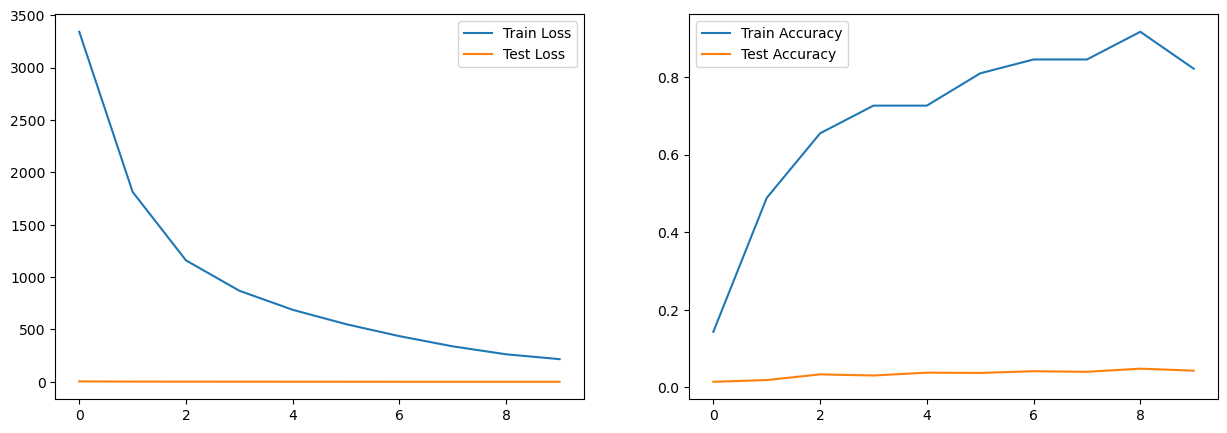

In [32]:
def plot_graphs(train_losses, train_acc, val_losses, val_acc):
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Test Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label="Train Accuracy")
    plt.plot(val_acc, label="Test Accuracy")
    plt.legend()
    plt.show()

cpu_trainloss, cpu_trainacc, cpu_vallosses, cpu_valacc = torch.tensor(train_losses, device='cpu'), torch.tensor(train_acc, device='cpu'), torch.tensor(val_losses, device='cpu'), torch.tensor(val_acc, device='cpu')

        
plot_graphs(cpu_trainloss, cpu_trainacc, cpu_vallosses, cpu_valacc)

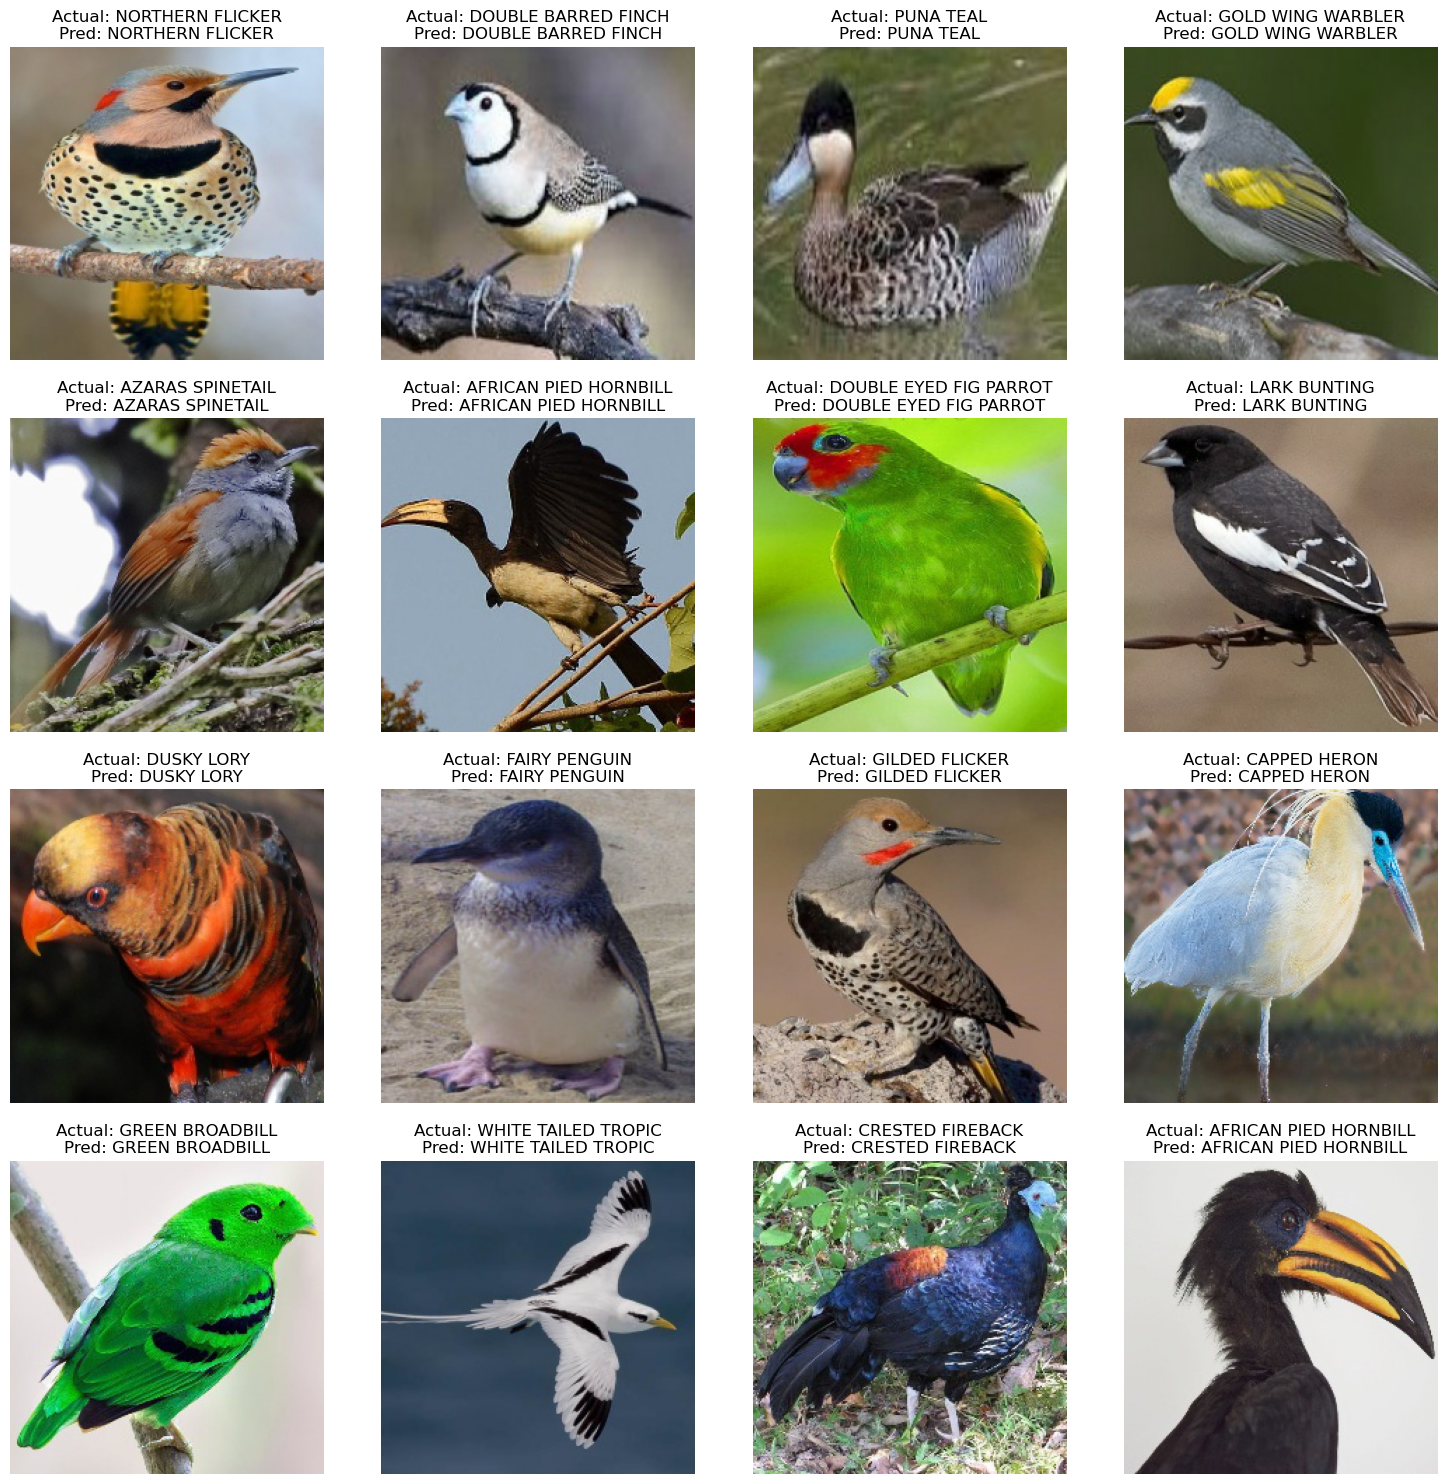

In [33]:
def show_test_batch(images, preds, targets, class_map):
    images = denormalize(images.cpu())
    images = images.numpy()
    preds = preds.cpu().numpy()
    targets = targets.cpu().numpy()

    fig, ax = plt.subplots(4, 4, figsize=(15, 15))
    fig.tight_layout()
    for i in range(4):
        for j in range(4):
            ax[i, j].imshow(np.transpose(images[i*4+j], (1, 2, 0)))
            ax[i, j].set_title(f"Actual: {class_map[targets[i*4+j]]}\nPred: {class_map[preds[i*4+j]]}")
            ax[i, j].axis("off")

images, targets = next(iter(test_dataloader))
images, targets = images.to(device), targets.to(device)
output = resnet(images)
preds = torch.argmax(output, dim=1)

show_test_batch(images, preds, targets, bird_name_map)